In [2]:
# Setting seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [82]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.math import confusion_matrix

In [4]:
!pip install kaggle

In [6]:
kaggle_credentails = json.load(open("kaggle.json"))

In [7]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [8]:
!ls

kaggle.json  sample_data


In [9]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:27<00:00, 114MB/s]
100% 2.04G/2.04G [00:27<00:00, 80.6MB/s]


In [10]:
!ls

kaggle.json  plantvillage-dataset.zip  sample_data


In [11]:
with ZipFile("plantvillage-dataset.zip",'r') as zip_e:
  zip_e.extractall();

In [12]:
print(os.listdir("plantvillage dataset"))

['grayscale', 'color', 'segmented']


In [13]:

print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

38
['Raspberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot']
38
['Raspberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot']
38
['Raspberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot']


In [14]:
print(len(os.listdir("plantvillage dataset/color/Raspberry___healthy")))
print(os.listdir("plantvillage dataset/color/Raspberry___healthy")[:5])

371
['2f28b03f-9110-4520-89fe-cdde93b84755___Mary_HL 9235.JPG', '7f719590-e1de-45b9-8ebf-96403795f185___Mary_HL 9210.JPG', 'ca39fd1a-4928-4438-b42b-38ca24437a88___Mary_HL 6282.JPG', '076d909d-cfca-47ce-a8d1-479bb77c4bab___Mary_HL 6294.JPG', '75d0565c-0e80-4cac-9f11-dfc537d68677___Mary_HL 6401.JPG']


Image Preprossing: ⏰

In [54]:
base_dir = "plantvillage dataset/color"

(256, 256, 3)


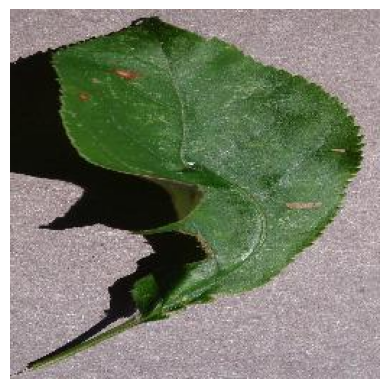

In [55]:
img_path = "/content/plantvillage dataset/color/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG"

img = mpimg.imread(img_path)
print(img.shape)
#Display the img
plt.imshow(img)
plt.axis('off')
plt.show()


In [56]:
#img parameters
img_size = 224   # resize to 244x244x3
batch_size = 32

In [57]:
# normalizating the images
data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2 # use 20% of data for validatioon
)

In [60]:
#train Generator // flow_from_directory - automatically finds classes and iamg
train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size, #we train the NN by passing images in batch, so that it can be easily stored in memory
    subset='training',
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.


In [61]:
#Validation Gen
val_gen = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size, #we train the NN by passing images in batch, so that it can be easily stored in memory
    subset='validation',
    class_mode = 'categorical'
)

Found 10849 images belonging to 38 classes.


In [62]:
#Model defination
model = models.Sequential()
# 32 filters of size 3x3
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(img_size,img_size,3)))
model.add(layers.MaxPooling2D(2,2))
# adding 64 filters cuz the deeper we go, we want to caputre complex details
model.add(layers.Conv2D(64,(3,3),activation='relu'))

model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
# the fully connected layer expects the data to be one dimentional
model.add(layers.Flatten())
# dense layer with 256 nurons
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dense(train_gen.num_classes,activation='softmax'))


In [63]:
model.summary()
# None = batch size

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 128)      

In [64]:
#compile the Model

In [65]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
#Trainign the Model
history = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // batch_size,
    epochs=10,
    validation_data = val_gen,
    validation_steps = val_gen.samples // batch_size,
)

Epoch 1/10
1358/1358 [==============================] - 106s 77ms/step - loss: 0.9102 - accuracy: 0.7338 - val_loss: 0.4080 - val_accuracy: 0.8681
Epoch 2/10
1358/1358 [==============================] - 105s 78ms/step - loss: 0.2992 - accuracy: 0.9037 - val_loss: 0.3463 - val_accuracy: 0.8878
Epoch 3/10
1358/1358 [==============================] - 105s 77ms/step - loss: 0.1743 - accuracy: 0.9419 - val_loss: 0.2819 - val_accuracy: 0.9144
Epoch 4/10
1358/1358 [==============================] - 103s 76ms/step - loss: 0.1216 - accuracy: 0.9606 - val_loss: 0.3501 - val_accuracy: 0.8993
Epoch 5/10
1358/1358 [==============================] - 104s 76ms/step - loss: 0.1007 - accuracy: 0.9666 - val_loss: 0.5327 - val_accuracy: 0.8693
Epoch 6/10
1358/1358 [==============================] - 100s 74ms/step - loss: 0.0843 - accuracy: 0.9729 - val_loss: 0.3339 - val_accuracy: 0.9194
Epoch 7/10
1358/1358 [==============================] - 105s 77ms/step - loss: 0.0741 - accuracy: 0.9766 - val_loss: 0

In [67]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(val_gen, steps=val_gen.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 [==============================] - 19s 56ms/step - loss: 0.3125 - accuracy: 0.9341
Validation Accuracy: 93.41%


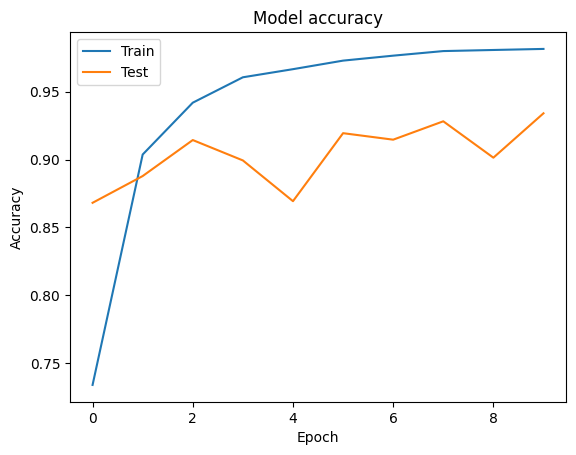

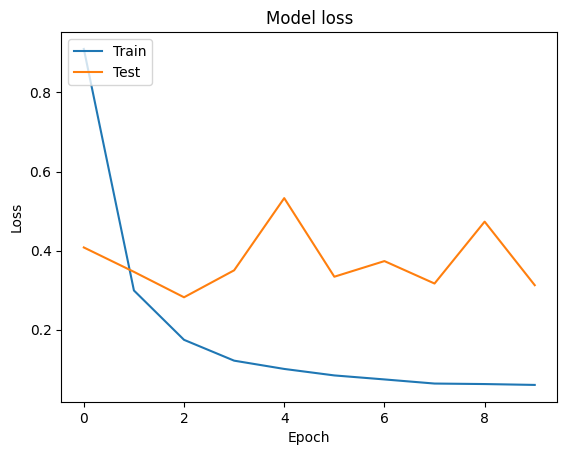

In [68]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Now trying to predict on the model**

In [69]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    # y = np.expand_dims(x, axis=0) // make the arry 2D
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values between [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    # get the max probability prediction
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    print(predicted_class_index)

    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [70]:
train_gen.class_indices.items()

dict_items([('Apple___Apple_scab', 0), ('Apple___Black_rot', 1), ('Apple___Cedar_apple_rust', 2), ('Apple___healthy', 3), ('Blueberry___healthy', 4), ('Cherry_(including_sour)___Powdery_mildew', 5), ('Cherry_(including_sour)___healthy', 6), ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 7), ('Corn_(maize)___Common_rust_', 8), ('Corn_(maize)___Northern_Leaf_Blight', 9), ('Corn_(maize)___healthy', 10), ('Grape___Black_rot', 11), ('Grape___Esca_(Black_Measles)', 12), ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 13), ('Grape___healthy', 14), ('Orange___Haunglongbing_(Citrus_greening)', 15), ('Peach___Bacterial_spot', 16), ('Peach___healthy', 17), ('Pepper,_bell___Bacterial_spot', 18), ('Pepper,_bell___healthy', 19), ('Potato___Early_blight', 20), ('Potato___Late_blight', 21), ('Potato___healthy', 22), ('Raspberry___healthy', 23), ('Soybean___healthy', 24), ('Squash___Powdery_mildew', 25), ('Strawberry___Leaf_scorch', 26), ('Strawberry___healthy', 27), ('Tomato___Bacterial_spot', 

In [71]:
class_indices = {v: k for k,v in train_gen.class_indices.items()}

In [43]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [72]:
json.dump(class_indices, open('class_indices.json', 'w'))

In [76]:

image_path = '/content/plantvillage dataset/color/Strawberry___Leaf_scorch/0024203d-6e4c-490f-b9a8-e5926df0b76e___RS_L.Scorch 0795.JPG'

predicted_class_name = predict_image_class(model, image_path, class_indices)

print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 18ms/step
26
Predicted Class Name: Strawberry___Leaf_scorch


In [77]:
model.save('/content/drive/MyDrive/Deep_learning/plant_disease_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:

y_pred = np.argmax(model.predict(val_gen), axis=1)
y_true = val_gen.classes
cm = confusion_matrix(y_true, y_pred)
print(cm)


340/340 [==============================] - 19s 55ms/step
tf.Tensor(
[[  4   1   1 ...   9   1   5]
 [  1   6   1 ...   9   0   3]
 [  0   0   0 ...   1   0   1]
 ...
 [ 11  18   5 ... 130   7  31]
 [  2   0   0 ...   9   0   2]
 [  5   1   1 ...  32   2   6]], shape=(38, 38), dtype=int32)


Text(0.5, 47.7222222222222, 'predicted lable')

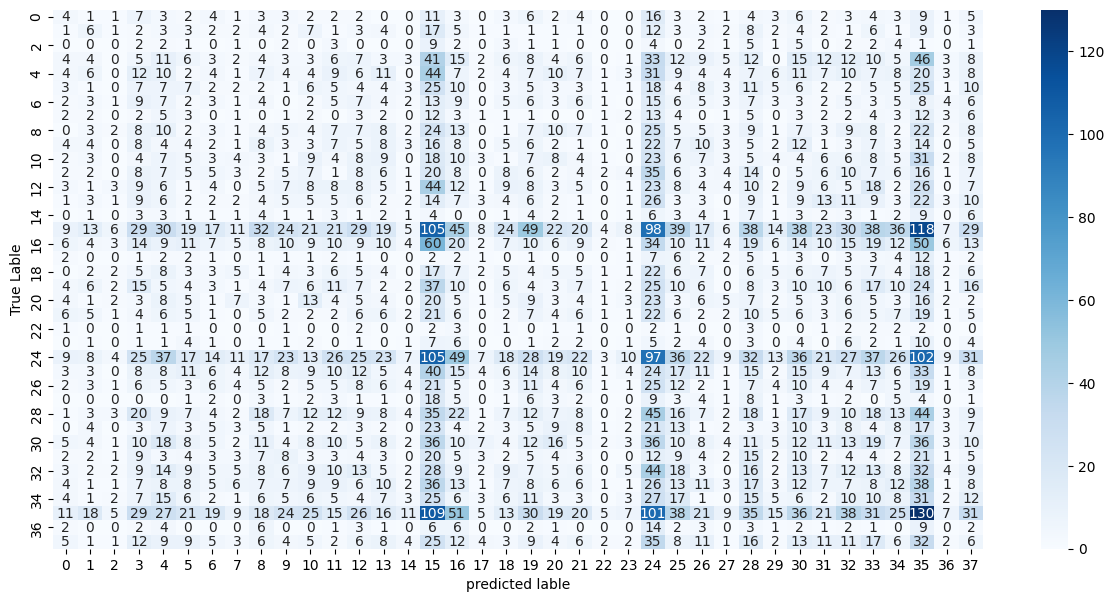

In [85]:
plt.figure(figsize=(15,7))
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.ylabel('True Lable')
plt.xlabel('predicted lable')